In [1]:
!conda install --yes --prefix {sys.prefix} matplotlib pandas scikit-learn scipy networkx jupyter
# !conda install --yes --prefix {sys.prefix} -c conda-forge/label/cf202003 infomap
!{sys.executable} -m pip install python-louvain multiprocess wurlitzer
!{sys.executable} -m pip install -e ../vendor/py
%matplotlib inline


EnvironmentLocationNotFound: Not a conda environment: C:\Users\ohund\workspace\project_network_science\src\{sys.prefix}

Der Befehl "{sys.executable}" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "{sys.executable}" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [2]:
import networkx as nx
from networkx.algorithms import community as algorithms
from networkx.generators import community as generator
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import normalized_mutual_info_score
import math 
import itertools
from collections import OrderedDict, Counter, deque
import pandas as pd
import multiprocess as mp
import matplotlib.cm as cm
import community as community_louvain
import scipy
from random import random
import operator

In [3]:
def extract_true_communities(G):
    communities = []
    for v in G:
        curr_community = G.nodes[v]['community']
        if not any([v in community for community in communities]):
            communities.append(frozenset(curr_community))
    partition = extract_partition_map(communities)
    return partition, communities

def extract_partition_map(communities):
    # print(communities)
    node_community_participation = {node:idx for idx, community in enumerate(communities) for node in community}
    return OrderedDict(sorted(node_community_participation.items()))

def extract_community_map(partition):
    v = {}
    for key, value in partition.items():
        v.setdefault(value, []).append(key)
    communities = list(dict(sorted(v.items())).values())
    return communities

def generate_benchmark_graph(n, mu=0.1):
    tau1 = 2 # Degree distribution power-law exponent
    tau2 = 1.1 # Community size distribtution power-law exponent
    G = generator.LFR_benchmark_graph(n, tau1, tau2, mu, min_degree=20, max_degree=50, max_iters=1000, seed=10)
    pos = nx.spring_layout(G, k=.3)
    return G, pos

def visualize_benchmark_graph(G, pos, partition = None, ax=None):
    if partition:
        cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
        nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                            cmap=cmap, node_color=list(partition.values()), ax=ax)
        nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
    else:
        nx.draw_networkx_nodes(G, pos, node_size=40, ax=ax)
        nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
    return None

def sort_partition_map(partition_map):
    return dict(sorted(partition_map.items()))    

def post_transform(algorithm):
    def modified_function(G):
        communities = algorithm(G)
        pred_partition_map = extract_partition_map(communities)
        return pred_partition_map
    modified_function.__name__ = algorithm.__name__
    return modified_function

Drawing some community network graphs and predictions


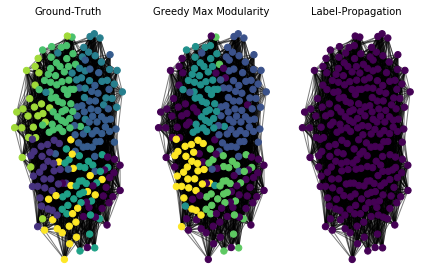

In [4]:
# %%
print(f"Drawing some community network graphs and predictions")
G, pos = generate_benchmark_graph(250,0.3)
true_partition_map, communities = extract_true_communities(G)
communities = algorithms.greedy_modularity_communities(G)
cnm_partition_map = extract_partition_map(communities)
communities = algorithms.asyn_lpa_communities(G)
lpa_partition_map = extract_partition_map(communities)

# fig = plt.figure(figsize=(10, 10), dpi= 80); #plt.clf()
fig, ax = plt.subplots(1, 3)
ax[0].set_title(f"Ground-Truth", fontsize=10)
ax[0].set_axis_off()
ax[1].set_title(f"Greedy Max Modularity ", fontsize=10)
ax[1].set_axis_off()
ax[2].set_title(f"Label-Propagation", fontsize=10)
ax[2].set_axis_off()
visualize_benchmark_graph(G, pos, true_partition_map, ax[0])
visualize_benchmark_graph(G, pos, cnm_partition_map, ax[1])
visualize_benchmark_graph(G, pos, lpa_partition_map, ax[2])
plt.tight_layout()
plt.show()

In [5]:
def compute_entropy(partition_map):
    class_counts = np.array(list(Counter(partition_map.values()).values()))
    class_probabilities = class_counts/sum(class_counts) 
    partial_entropies = - class_probabilities * np.log2(class_probabilities)
    entropy = partial_entropies.sum() 
    return entropy

def compute_conditional_entropy(hx, hy, hxy):
    return hx + hy - hxy

def compute_joint_entropy(true_partitions, pred_partitions):
    cnt_matrix = contingency_matrix(list(true_partitions.values()), list(pred_partitions.values())).T
    matrix_sum = cnt_matrix.sum()
    prob_matrix = cnt_matrix / matrix_sum
    joint_entorpy = -np.nansum(prob_matrix*np.log2(prob_matrix))
    return joint_entorpy

def normalized_mutual_information(true_partitions, pred_partitions):
    H_X = compute_entropy(true_partitions)
    H_Y = compute_entropy(pred_partitions)
    H_XY = compute_joint_entropy(true_partitions, pred_partitions)
    conditional_entropy =  compute_conditional_entropy(H_X, H_Y, H_XY)
    sum_of_independent_entropies = H_X + H_Y
    nominator = 2 * conditional_entropy
    denominator = sum_of_independent_entropies
    return nominator/denominator

true_nmi = normalized_mutual_information(true_partition_map, true_partition_map)
cnm_nmi = normalized_mutual_information(true_partition_map, cnm_partition_map)
cnm_nmi_reversed = normalized_mutual_information(cnm_partition_map, true_partition_map)
lpa_nmi = normalized_mutual_information(true_partition_map, lpa_partition_map)

assert math.isclose(true_nmi, 1), f"True nmi does not equal one with the score of {true_nmi}"
print(f"NMI of true prediction with true prediction amounts to {true_nmi} == 1.0.")

assert cnm_nmi < 1, f"Clauset-Moore-Newman not below 1 with {cnm_nmi}"
print(f"NMI of ground truth with cnm prediction amounts to {cnm_nmi} < 1")

assert cnm_nmi == cnm_nmi_reversed, f"NMI score for NMI(X,Y) is not the same as NMI(Y,X)"
print(f"Reversed NMI score is {cnm_nmi_reversed}")

assert cnm_nmi < 1, f"Label propagation is not below 1 with {lpa_nmi}"
print(f"NMI of ground truth with lpa prediction amounts to {lpa_nmi} < 1")

NMI of true prediction with true prediction amounts to 1.0 == 1.0.
NMI of ground truth with cnm prediction amounts to 0.7699400310176202 < 1
Reversed NMI score is 0.7699400310176202
NMI of ground truth with lpa prediction amounts to 0.0 < 1


<ipython-input-5-ea12ea9879d4>:15: RuntimeWarning: divide by zero encountered in log2
  joint_entorpy = -np.nansum(prob_matrix*np.log2(prob_matrix))
<ipython-input-5-ea12ea9879d4>:15: RuntimeWarning: invalid value encountered in multiply
  joint_entorpy = -np.nansum(prob_matrix*np.log2(prob_matrix))


In [6]:
import utils
algorithms_for_experiment = {
    # modified_girvan_newman(): "Girvan-Newman",
    utils.post_transform(algorithms.greedy_modularity_communities):"Greedy Modularity Maximization",
    utils.post_transform(algorithms.asyn_lpa_communities):"Label Propagation",
    community_louvain.best_partition:"Louvain Algorithm"
    }
collected_data = []
iterations = list(range(0,1))
node_sizes = [250]
mus = np.arange(0.1, 1.1-0.9, 0.1)
configuration_set = itertools.product(*[iterations, algorithms_for_experiment.items(), node_sizes, mus])

cpu_cnt = mp.cpu_count()
with mp.Pool(cpu_cnt) as pool:
    print(f"Running experiments in parallel with {cpu_cnt} cpus")
    parallel_execution_data = pool.map(utils.compute_experiment, configuration_set)

data = pd.DataFrame(parallel_execution_data)
data.head()

Running experiments in parallel with 12 cpus


,method,N,µ,NMI
0,Greedy Modularity Maximization,250,0.1,0.991647
1,Greedy Modularity Maximization,250,0.2,0.870207
2,Label Propagation,250,0.1,0.914620
3,Label Propagation,250,0.2,0.841032
4,Louvain Algorithm,250,0.1,1.000000


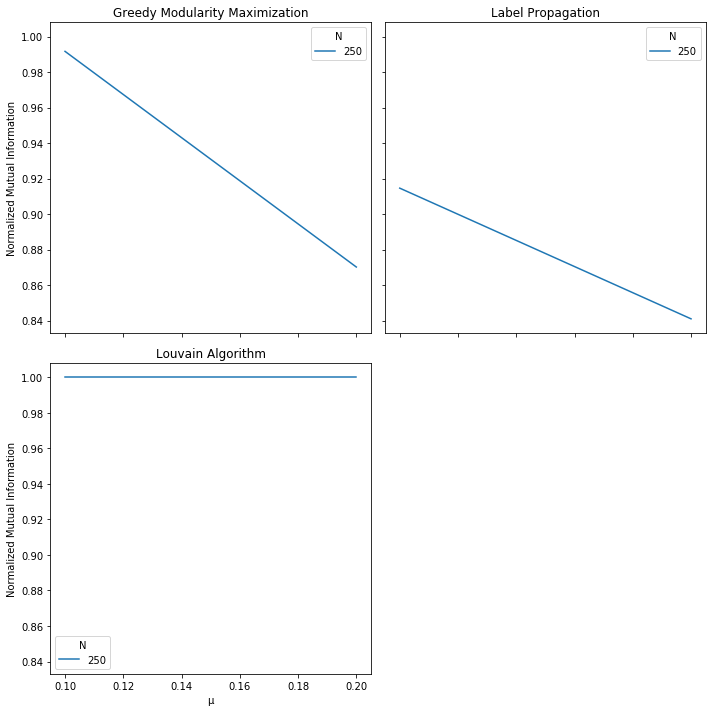

In [7]:
def draw_plots(data):
    aggregated_over_trials = data.groupby(['method', 'N', 'µ']).mean()
    grouped_by_algorithm = aggregated_over_trials.groupby(['method'])
    num_groups = len(grouped_by_algorithm)
    num_rows = int(math.ceil(num_groups/2))
    tmp = None
    fig, axes = plt.subplots(num_rows, 2, sharex=True, sharey=True) 
    fig.set_size_inches(10, 5*num_rows)
    axes = axes.flatten()
    for idx, (algorithm_name, algorithm_data) in enumerate(grouped_by_algorithm):
        axes[idx].set_title(algorithm_name)
        tmp = algorithm_data.reset_index().pivot(index='µ', columns='N', values='NMI')
        tmp.plot(ax=axes[idx])
        axes[idx].set_ylabel("Normalized Mutual Information")

    if num_groups < len(axes):
        fig.delaxes(*axes[num_groups:])
    fig.set_tight_layout(True)
    return plt.show()

draw_plots(data)

In [ ]:
import utils
from algorithms.louvain_core import LouvainCoreAlgorithm


louvain_algorithm = LouvainCoreAlgorithm(fitness_function=utils.modularity_wrapper, verbose=False, max_iter=20)
infomap_algorithm = LouvainCoreAlgorithm(fitness_function=utils.map_equation_wrapper, verbose=False, max_iter=20)
coverage_algorithm = LouvainCoreAlgorithm(fitness_function=utils.coverage_wrapper, verbose=False, max_iter=20)
lblprob_algorithm = utils.post_transform(algorithms.asyn_lpa_communities)



algorithms_for_experiment = {
    lblprob_algorithm:"Labelpropagation Algorithm",
    infomap_algorithm.run:"Map Equation",
    louvain_algorithm.run: "Louvain Algorithm",
    coverage_algorithm.run:"Coverage Maximization",
    }

collected_data = []
iterations = list(range(0, 1))
node_sizes = [250]
mus = np.arange(0.1, 0.6, 0.1)
configuration_set = itertools.product(*[iterations, algorithms_for_experiment.items(), node_sizes, mus])


cpu_cnt = mp.cpu_count()-2
print(cpu_cnt)
with mp.Pool(cpu_cnt) as pool:
    print(f"Running experiments in parallel with {cpu_cnt} cpus")
    parallel_execution_data = pool.map(utils.compute_experiment, configuration_set)

data = pd.DataFrame(parallel_execution_data)
data.head()

Inititalizing algorithm with run_iteration
Inititalizing algorithm with run_iteration
Inititalizing algorithm with run_iteration
10
Running experiments in parallel with 10 cpus


In [ ]:
draw_plots(data)

In [ ]:
data.to_csv('data-200602-1300.csv', index=False)